# Calculated power for adult multivariate contrasts 
### Univariate contrast to measure event organization across regions of interest (ROI)
#### Measure: Univariate difference from chance (permutation) at event boundaries between ROIs for adults - T-test

#### Fandakova et al. 2019
The authors here have adults and children encode scene-object pairings for a memory retrieval task. 

In [15]:
# load modules
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.power import FTestAnovaPower, TTestIndPower, TTestPower
from pingouin import ttest, anova
import pingouin as pg
data_dir = 'plots_from_papers'
%matplotlib inline

In [4]:
# simulate samples for each roi given the mean and sd of decoding ability (from plot of paper)
n_child = 93
n_adult = 31
filename = 'fandakova_2019_kids-adults/fandakova_2019_adults-kids_50vox_rois.csv'
file = os.path.join(data_dir, filename)
tmp1 = pd.read_csv(file, header=None)
tmp1.columns = ['group', 'dtype', 'num_val']
groups =  tmp1.group.values[0::2]
rois = tmp1.dtype.values[0::2]
means = tmp1.num_val.values[0::2]
sds = tmp1.num_val.values[1::2]
tmp2 = pd.DataFrame({ 'groups':groups, 'rois':rois, 'means':means, 'sds':sds })
df_list = list()
for i, row in tmp2.T.iteritems():
    if row.groups =='child':
        grp = np.repeat(['child'], n_child)
        vals = np.random.normal(row.means, row.sds - row.means, n_child)
    else:
        grp = np.repeat(['adult'], n_adult)
        vals = np.random.normal(row.means, row.sds - row.means, n_adult)
    df = pd.DataFrame([grp, vals], index=['group', 'decode']).T
    df['decode'] = df['decode'].astype('float')
    df['roi'] = row.rois
    df['ttest'] = i
    df_list.append(df)
df = pd.concat(df_list)

In [5]:
nsim = 1000
test_list = list()
for i in range(len(df.ttest.unique())):
    for frac in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]: # different fractions of full sample (N=93 child, N=31 adult)
        rdf = df.query(f'ttest=={i}')
        for sim in range(nsim):
            frdf = rdf.sample(frac=frac)
            tt = ttest(frdf.loc[:,'decode'].values, 33, paired=False, alternative='greater')
            tt['samples'] = len(frdf)
            tt['roi'] = frdf.roi.unique()[0]
            tt['group'] = frdf.group.unique()[0]
            test_list.append(tt)
multi_tt_full = pd.concat(test_list)

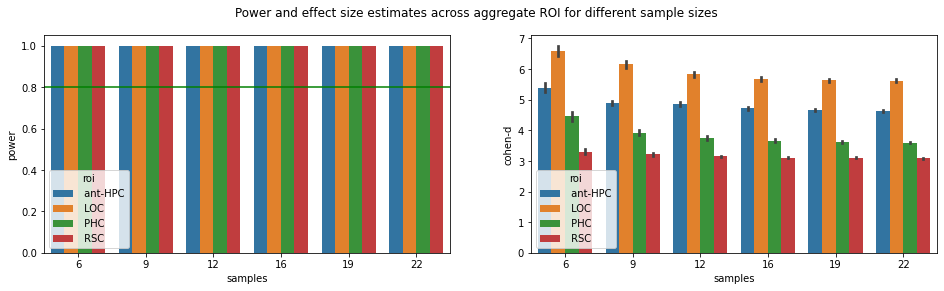

In [16]:
odf = multi_tt_full.query("group == 'adult'")
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.barplot(ax=ax[0], data=odf, x='samples', hue='roi', y='power')
sns.barplot(ax=ax[1], data=odf, x='samples', hue='roi', y='cohen-d')
fig.suptitle('Power and effect size estimates across aggregate ROI for different sample sizes')
ax[0].axhline(0.8, color='g')
None

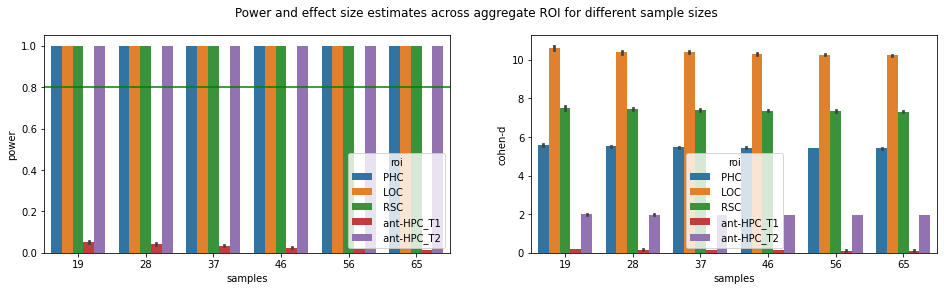

In [17]:
odf = multi_tt_full.query("group == 'child'")
fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.barplot(ax=ax[0], data=odf, x='samples', hue='roi', y='power')
sns.barplot(ax=ax[1], data=odf, x='samples', hue='roi', y='cohen-d')
fig.suptitle('Power and effect size estimates across aggregate ROI for different sample sizes')
ax[0].axhline(0.8, color='g')
None

Effect Size Children: 0.57, Effect Size Adults: 0.53


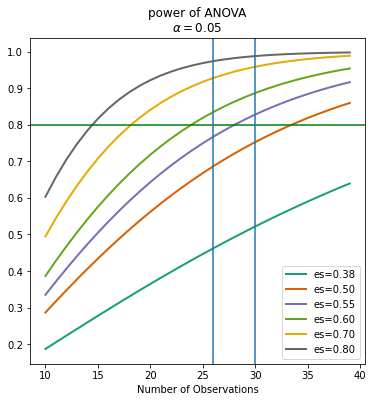

In [34]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1,1)
fig = FTestAnovaPower().plot_power(dep_var='nobs',
                                   nobs = np.arange(10, 40),
                                   effect_size = np.array([0.381, 0.5, 0.55, 0.6, 0.7, 0.8]),
                                   alpha = 0.05,
                                   ax=ax, title='power of ANOVA' + '\n' + r'$\alpha = 0.05$')
plt.axhline(0.8, color = 'g')
plt.axvline(26)
plt.axvline(30)

# getting example sample size for an expected effect size
power = 0.8
alpha = 0.05
power_analysis = FTestAnovaPower()
result1 = power_analysis.solve_power(power=power, nobs=26, alpha=alpha)
result2 = power_analysis.solve_power(power=power, nobs=30, alpha=alpha)
print(f'Effect Size Children: {result1:0.2f}, Effect Size Adults: {result2:0.2f}' )

# Summary for children and adults.

The simulations support the notion that the experimental design of 48 scene presentations for 3 scenes produces a strong effect size. This is further supported by simulating their test statistic with fewer participants and still seeing a strong effect size. By comparison we will be testing for both effects greater